# Scene Recognition Using Bag of Words
##  بخش ۱

ابتدا با توجه به فایل‌های ورودی، عکس‌ها را به صورت دسته‌بندی شده می‌خوانیم و آن‌‌ها را بر اساس دسته‌شان برچسب میزنیم.

برای قسمت ساخت بردار‌های هر عکس، با آزمون و خطا، بردار ۸×۸ بهترین دقت را داشت و این را به عنوان بردار تا انتهای کد
در نظر می‌گیریم.

برای انجام این مدل‌سازی، ابتدا هر عکس را به سایز ۸×۸ با درونیابی تبدیل می‌کنیم و بردار ویژگی به دست می‌آید.
سپس تمامی بردار‌های ترین را در یک فضا در نظر می‌گیریم و برای پیش‌بینی دسته هر بردار تست، از $KNN$ با نرم $L_1$ استفاده می‌کنیم که ریزالت بهتری از نرم $L_2$ می‌دهد.
البته همواره در هر یک از مراحل برای تصمیم‌گیری بهترین پارامتر، از $\text{K-Fold Validation}$ روی داده ترین استفاده می‌کنیم و با داده تست کاری نداریم.

در نهایت برای به دست آوردن دقت، برچسب‌های صحیح و برچسب‌های پیش‌بینی شده را در نظر می‌گیریم و درصد پیش‌بینی‌های صحیح را به دست می‌آوریم.


In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import os


def find_train_test_files(root_path, train_dir='Train', test_dir='Test'):
    category_names = []
    train_imgs = []
    train_labels = []
    test_imgs = []
    test_labels = []
    for root, dirs, files in os.walk(root_path):
        fs = root.replace(root_path, '').split(os.sep)
        if len(fs) != 2:
            continue
        category_name = fs[1]
        if category_name not in category_names:
            category_names.append(category_name)
        category_index = category_names.index(category_name)
        for f in files:
            img = cv.imread(os.path.join(root, f), cv.IMREAD_GRAYSCALE)
            if fs[0] == train_dir:
                train_imgs.append(img)
                train_labels.append(category_index)
            elif fs[0] == test_dir:
                test_imgs.append(img)
                test_labels.append(category_index)
    return train_imgs, np.array(train_labels), test_imgs, np.array(test_labels), category_names


root_path = './data/hw3/Data/'

train_imgs, train_labels, test_imgs, test_labels, category_names = find_train_test_files(root_path)

در ادامه، قطعه کدی که با $KNN$ دسته‌بندی می‌کند آمده‌است. در صورتی که $k=1$ قرار دهیم، به $NN$ تبدیل می‌شود.

In [2]:
def simple_knn_predictor(train_imgs, train_labels, test_imgs, test_labels, knn_val, f_size,
                         weights='distance', metric='minkowski', p=1):
    train_imgs_d = np.array([cv.resize(img, (f_size, f_size), interpolation=cv.INTER_AREA).ravel()
                             for img in train_imgs])
    test_imgs_d = np.array([cv.resize(img, (f_size, f_size), interpolation=cv.INTER_AREA).ravel()
                            for img in test_imgs])

    accs = []
    skf = StratifiedKFold()
    for train_idx, valid_idx in skf.split(train_imgs_d, train_labels):
        clf = KNeighborsClassifier(n_neighbors=knn_val, weights=weights, metric=metric, p=p)
        clf.fit(train_imgs_d[train_idx], train_labels[train_idx])
        accs.append(accuracy_score(train_labels[valid_idx], clf.predict(train_imgs_d[valid_idx])))

    clf = KNeighborsClassifier(n_neighbors=knn_val, weights=weights, metric=metric, p=p)
    clf.fit(train_imgs_d, train_labels)
    pred = clf.predict(test_imgs_d)

    return pred, np.average(accs), accuracy_score(test_labels, pred)

در ادامه، قطعه‌کدی را داریم که دقت‌های ترین را برای پارامتر‌های مختلف سایز بردار به دست می‌دهد.
دقت کنید که

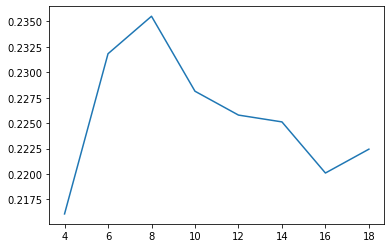

In [3]:
accs = []
for i in range(4, 20, 2):
    acc = simple_knn_predictor(train_imgs, train_labels, test_imgs, test_labels,
                               knn_val=1, f_size=i, weights='uniform')[1]
    accs.append((i, acc))
accs = np.array(accs)
plt.plot(accs[:, 0], accs[:, 1])
plt.show()

و همانطور که می‌بینید، در $k=1$ بهترین نتیجه با بردار ۸×۸ به دست می‌آید.

In [4]:
# best result using nn
nn_best = simple_knn_predictor(train_imgs, train_labels, test_imgs, test_labels,
                               knn_val=1, f_size=8, p=1)
print('Nearest Neighbor:')
print(f'    train accuracy is {100 * nn_best[1]:.2f} and test accuracy is {100 * nn_best[2]:.2f}')

Nearest Neighbor:
    train accuracy is 23.55 and test accuracy is 25.13


حال عملیات بالا را برای بهینه‌سازی پارامتر روی مقدار $k$ انجام می‌دهیم. البته این‌بار، در $KNN$ با توجه به اینکه تعداد بیشتری همسایه در نظر می‌گیریم، برای رای‌گیری میان همسایه‌‌ها به نسبت فاصله‌شان وزن برای رای‌شان قائل می‌شویم:

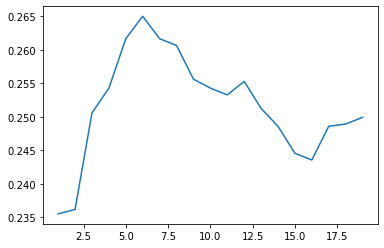

In [5]:
accs = []
for i in range(1, 20, 1):
    acc = simple_knn_predictor(train_imgs, train_labels, test_imgs, test_labels,
                               knn_val=i, f_size=8, weights='distance', p=1)[1]
    accs.append((i, acc))
accs = np.array(accs)
plt.plot(accs[:, 0], accs[:, 1])
plt.show()

همانطور که می‌بینید، بهترین نتیجه برای $k=6$ به دست می‌آید. حال روی داده‌های تست اجرا می‌کنیم:

In [7]:
# best result using knn
knn_value = 6
knn_best = simple_knn_predictor(train_imgs, train_labels, test_imgs, test_labels,
                                knn_val=knn_value, f_size=8, weights='distance', p=1)
print(f'K Nearest Neighbor: with k={knn_value}')
print(f'    train accuracy is {100 * knn_best[1]:.2f} and test accuracy is {100 * knn_best[2]:.2f}')



K Nearest Neighbor: with k=6
    train accuracy is 26.50 and test accuracy is 24.73
